In [0]:
# !nvidia-smi

In [0]:
# !pip install fastai2
# !pip install git+https://github.com/lgvaz/faststyle.git

In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from faststyle import *

In [0]:
source = untar_data(URLs.COCO_SAMPLE)

In [0]:
# Fix styles for colab
style_dir = Path('styles')
style_fns = L(style_dir/'abstract.jpg', style_dir/'starry_night.jpg')

In [0]:
dblock = DataBlock(style_blocks, get_items=get_image_files, splitter=RandomSplitter(.1),
                   item_tfms=[Resize(256)],
                   batch_tfms=[*aug_transforms(), NormalizeX.from_stats(*coco_stats)])

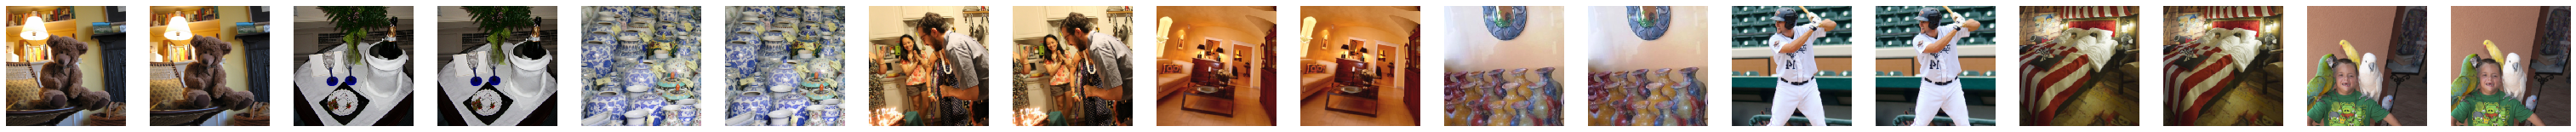

In [7]:
dls = dblock.dataloaders(source, bs=22)
dls.show_batch(rows=1)

In [0]:
get_feats = LayerFeats.from_feat_m(FeatModels.vgg19)

In [0]:
m = TransformerNet()
learn = style_learner(dls, m, get_feats, style_fns)

In [0]:
# learn.lr_find()

In [11]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,time
0,9.170748,11.643714,18:10


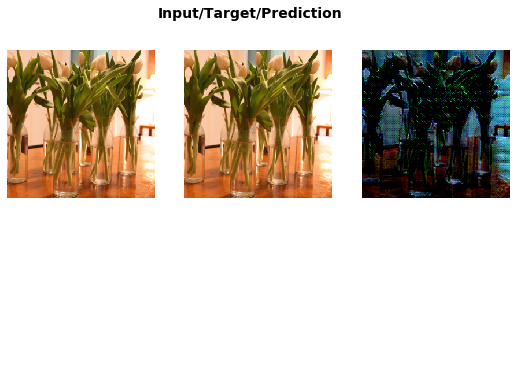

In [12]:
learn.show_results(max_n=1)